In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
import vehicle_list_data
from simulation import Simulation
from vehicle_list_data import get_index_edge_totals
from tqdm import tqdm
from ast import literal_eval
# from vehicle import get_edge_type_frequencies

In [25]:
file_path = "trials/low_volume_noreverse/"

# Labels

In [37]:
reverse_scenario_labels = ["all_improved", "double_battery_capacity", "double_km_per_kwh", "double_charging_rate", "baseline"]
scenario_labels = list(reversed(reverse_scenario_labels))

# Sort Pickles

In [113]:
num_scenarios = len(scenario_labels)
def get_pickles_by_scenario(file_path):
    pkls = os.listdir(file_path)
    per_scenario = {str(n):[] for n in range(num_scenarios)}
    for scenario in range(num_scenarios):
        for pkl in pkls:
            end_index = pkl.find('_algorithm_')
            if "scenario_"+str(scenario) in pkl or pkl[end_index-1:end_index]==str(scenario):
                per_scenario[str(scenario)].append(pkl)
    per_scenario = {key:sorted(per_scenario[key]) for key in per_scenario}
    return per_scenario
per_scenario = get_pickles_by_scenario(file_path)
per_scenario;

# Graph Scenarios over Algorithm Iterations

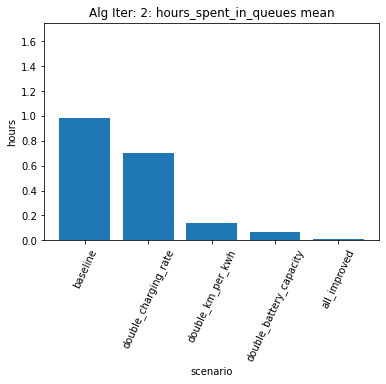

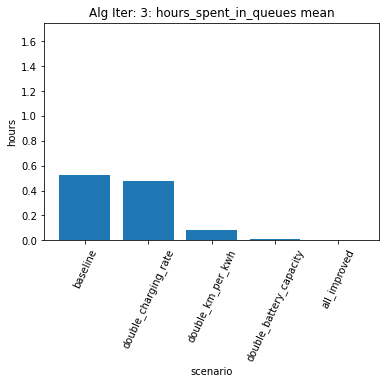

In [153]:
num_scenarios = len(list(per_scenario.keys()))
def graph_scenario(n, metric = "station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for pkl in per_scenario[str(n)]:
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("Scenario " + scenario_labels[n] + ": " + metric + " " + measurement_str)
    plt.ylabel("hour")
    plt.xlabel("iteration")
    plt.show()

def graph_algo_iteration(a, metric="station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for scenario in per_scenario:
        pkl = per_scenario[scenario][a]
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    fig, ax = plt.subplots(figsize = (6,4))
    ax.bar(list(range(len(scenario_labels))), data)
    measurement_str = measurement if measurement != None else ""
    ax.set_title("Alg Iter: " + str(a) + ": " + metric + " " + measurement_str)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(scenario_labels, rotation=65)
    ax.set_xlabel('scenario')
    ax.set_ylabel('hours')
    ax.set_ylim(0,1.75)
    plt.show()

# for scenario in range(num_scenarios):
#     graph_scenario(scenario, metric = "hours_spent_in_queues", measurement = None)
    
for algo_iter in range(2,4):
    graph_algo_iteration(algo_iter, metric = "hours_spent_in_queues", measurement = "mean")

# Extract Charging Station Information

In [43]:
def get_stations_used_passed(path):
    stations_used = []
    stations_passed = []
    for i, loc in enumerate(path):
        if i == len(path):
            break
        if "_in" in loc:
            next_loc = path[i+1]
            in_battery = loc.split("_")[1]
            out_battery = next_loc.split("_")[1]
            if "_out" in next_loc:
                node = loc.split("_")[0]
                if in_battery != out_battery:
                    stations_used.append(node)
                else:
                    stations_passed.append(node)
    return (stations_used, stations_passed)

def get_utilization_df(sim):
    station_used_counts = {node:0 for node in sim.station_g.nodes}
    station_passed_counts = {node:0 for node in sim.station_g.nodes}

    for vehicle in sim.vehicle_list:
        stations_used, stations_passed = get_stations_used_passed(vehicle.path)
        for station in stations_used:
            station_used_counts[station]+=1
        for station in stations_passed:
            station_passed_counts[station]+=1
    utilization_data = np.array([list(station_used_counts.keys()), list(station_used_counts.values()), list(station_passed_counts.values())]).T
    utilization_df = pd.DataFrame(utilization_data, columns = ["node", "used", "passed"])
    utilization_df = utilization_df.astype({"used": int, "passed": int})
    return utilization_df

def get_charging_passed_unseen(sim):
    utilization_df = get_utilization_df(sim)
    num_stations_unseen = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]==0)])
    num_stations_passed = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]!=0)])
    num_stations_charging = len(utilization_df.loc[(utilization_df["used"]!=0)])
    return (num_stations_charging, num_stations_passed, num_stations_unseen)

get_charging_passed_unseen(sim)

(37, 0, 6)

# Assess src-dst distribution

In [44]:
print("Total vehicles: ", len(sim.vehicle_list))

Total vehicles:  11621


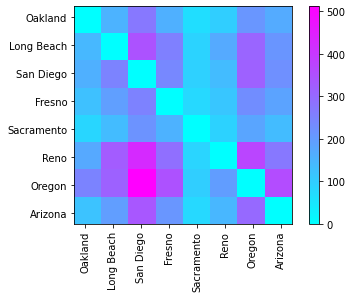

In [78]:
def get_src_dst_dict(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    destinations = {dst:0 for dst in demand_nodes}
    sources = {src:0 for src in demand_nodes}
    paths = {(src+"_src", dst+"_dst"):0 for src in demand_nodes for dst in demand_nodes}

    for vehicle in sim.vehicle_list:
        destinations[vehicle.dst]+=1
        sources[vehicle.src]+=1
        paths[(vehicle.src+"_src", vehicle.dst+"_dst")] +=1
    return paths;
    
def plot_src_dst_matrix(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    paths = get_src_dst_dict(sim)
    path_matrix = np.zeros((num_demand_nodes,num_demand_nodes))
    for r, src in enumerate(demand_nodes):
        for c, dst in enumerate(demand_nodes):
            path_matrix[r][c] = paths[(src+"_src",dst+"_dst")]
            
    fig, ax = plt.subplots(1,1)

    img = ax.imshow(path_matrix, cmap='cool', interpolation='nearest',extent=[-1,1,-1,1])
    ax.set_xticks(np.linspace(-.9, .9,len(demand_nodes)))
    ax.set_xticklabels(demand_nodes,rotation=90)
    ax.set_yticks(np.linspace(-.9, .9,len(demand_nodes)))
    ax.set_yticklabels(list(reversed(demand_nodes)),rotation=0)
    fig.colorbar(img)

plot_src_dst_matrix(sim)

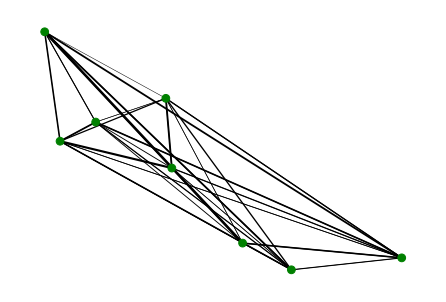

In [99]:
demand_nodes = list(sim.dst_dict.keys())
path_weights = get_src_dst_dict(sim)
G = sim.station_demand_g.subgraph(demand_nodes).copy()
sim_index = 50
G.add_edges_from([(src, dst) for src in demand_nodes for dst in demand_nodes if src!=dst])
for node in G.nodes:
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 60
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {(src,dst):path_weights[(src+'_src', dst+"_dst")]/200 for src in demand_nodes for dst in demand_nodes}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Static Graph

In [70]:
edge_totals = get_index_edge_totals(sim)

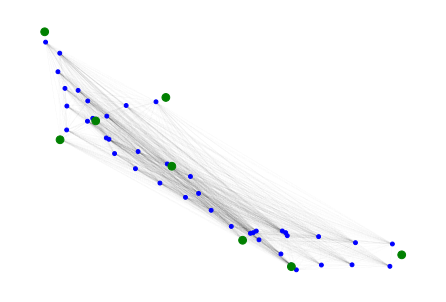

In [71]:
G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 15
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 60
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {edge:.005 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Assess demand (vehicles on each road)

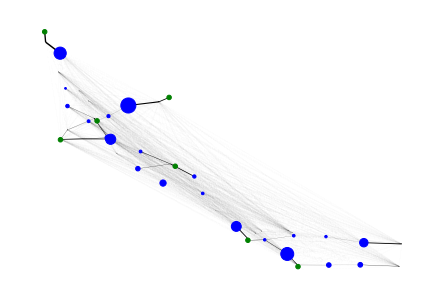

In [157]:
G = sim.station_demand_g
sim_index = 25
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 0
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Confirm queue charging and total at-station time

In [105]:
def get_time_at_charging_station(locations):
    sim_steps = 0
    for i, loc in enumerate(locations):
        if i == len(locations):
            break
        if "_in" in loc[0] and "_out" in loc[1]:
            in_battery = loc[0].split("_")[1]
            out_battery = loc[1].split("_")[1]
            if in_battery != out_battery:
                sim_steps+=1
    return sim_steps

In [106]:
charging_and_queue_time = []
charging_and_queue_time_sim = []
for vehicle in sim.vehicle_list:
    charging_and_queue_time.append(get_time_at_charging_station(vehicle.locations))
    charging_and_queue_time_sim.append(vehicle.queue_time)
qc_arr = np.array([charging_and_queue_time, charging_and_queue_time_sim]).T
qc_df = pd.DataFrame(qc_arr/5, columns = ["qc", "q_sim"])
print(max(qc_df["qc"]), max(qc_df["q_sim"]))

10.6 10.0


# Do vehicles with the same src dst take different paths?

In [107]:
# sim_index = "2"
# alg_index = 3
# with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
#     sim = pickle.load(inp)
    
pkl = "trials/debug/huge_queue_cost_trial_05_02_2022_15_59_14.pkl"
with open(pkl, 'rb') as inp:
    sim = pickle.load(inp)
    
def get_trip_unique_paths(sim):
    demand_nodes = list(sim.dst_dict.keys())
    trips = {(src, dst):{} for src in demand_nodes for dst in demand_nodes}
    for vehicle in sim.vehicle_list:
        if tuple(vehicle.path) in trips[(vehicle.src, vehicle.dst)]:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]+=1
        else:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]=0
    return trips

def get_number_trip_unique_paths(sim):
    trips = get_trip_unique_paths(sim)
    return [len(trips[key]) for key in trips]


print(get_number_trip_unique_paths(sim))

[0, 4, 4, 2, 2, 4, 5, 3, 0, 1, 3, 4, 3, 6, 3, 1, 0, 2, 5, 3, 5, 1, 2, 3, 0, 3, 1, 3, 1, 5, 6, 2, 0, 2, 4, 2, 6, 6, 3, 2, 0, 2, 5, 6, 6, 5, 5, 3, 0]


# Compare metrics (csv)

    scenario_number  station_utilization_avg_of_disp  electricity  \
0                 0                         6.635417            0   
5                 1                         7.614063            0   
10                2                         3.306250            0   
15                3                         4.344271            0   
20                4                         2.349740            0   

    percent_delay  hours_spent_in_queues  
0        2.381675               1.530435  
5        1.977342               0.875472  
10       1.193477               0.061333  
15       1.316734               0.173399  
20       1.022456               0.008368  


Text(0, 0.5, 'Cumulative Penalty')

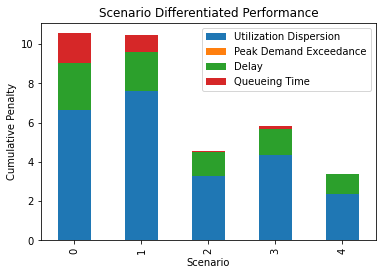

In [54]:
# Plot
# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
  
# create data
file_path = "trials/low_volume_noreverse/"
metrics = pd.read_csv(file_path+"low_volume_noreverse.csv", header=1) #, dtype={'percent_delay':list, 'hours_spent_in_queues':list})
metrics = metrics[metrics['iteration']==0]

metrics = metrics[["scenario_number", "station_utilization_avg_of_disp", "electricity", "percent_delay", "hours_spent_in_queues"]]
# print(metrics)
metrics["percent_delay"] = metrics["percent_delay"].apply(lambda x: float(x.split(', ')[3]))
metrics["hours_spent_in_queues"] = metrics["hours_spent_in_queues"].apply(lambda x: float(x.split(', ')[3]))

# view data
print(metrics)
  
# plot data in stack manner of bar type
fig, ax = plt.subplots()
metrics.plot(x='scenario_number', kind='bar', ax=ax, stacked=True,
        title='Scenario Differentiated Performance')
ax.legend(["Utilization Dispersion", "Peak Demand Exceedance", "Delay", "Queueing Time"])
ax.set_xlabel("Scenario")
ax.set_ylabel("Cumulative Penalty")

2 and 4 have high vehicle efficiency (kwh/km is low), 3 and 4 have larger battery storage (kwh capacity is large)

In [46]:
metrics

,scenario_number,station_utilization_avg_of_disp,electricity,percent_delay,hours_spent_in_queues
0,0,6.635417,0,2.3816753800055364,1.5304347826086957
5,1,7.614063,0,1.9773419355678385,0.8754716981132076
10,2,3.306250,0,1.1934767563867341,0.06133333333333334
15,3,4.344271,0,1.3167342773057937,0.17339901477832514
20,4,2.349740,0,1.0224564464791959,0.008368200836820083


In [13]:
file_path = "trials/low_volume_noreverse/"
scenarios_df = pd.read_csv(file_path+"low_volume_noreverse.csv", header=1)
scenarios_df.head(5)

,0,scenario_number,iteration,charging_rate,km_per_kwh,battery_capacity,success,station_utilization_disp_of_avg,station_utilization_avg_of_disp,electricity,percent_delay,hours_spent_in_queues,hours_spent_charging,most_utilized_node,least_utilized_node,strongly_connected_components,weakly_connected_components
0,1,0,0,45,1.9,215,True,6.553906,6.635417,0,"(1.0, 2.4598439829250043, 4.2518900502485035, ...","(0.0, 0.1, 5.4, 1.5304347826086957, 1.76793536...","(0, 9.0, 36, 9.695652173913043, 11.09811884807...",8,1,296,44
1,2,0,1,45,1.9,215,True,5.055990,5.187760,0,"(1.0, 2.125945075568434, 3.9636855689403414, 1...","(0.0, 0.0, 3.4, 0.32727272727272727, 0.6981676...","(0, 9.0, 35, 6.931818181818182, 7.750066648607...",16,2,292,44
2,3,0,2,45,1.9,215,True,5.956510,6.250521,0,"(1.0, 2.00431736629579, 4.067025361957004, 2.1...","(0.0, 0.0, 4.4, 0.9802197802197803, 1.51825664...","(0, 9.0, 38, 6.010989010989011, 7.018804421365...",37,3,280,45
3,4,0,3,45,1.9,215,True,4.846615,5.038281,0,"(1.0, 2.00431736629579, 4.159457756546936, 1.8...","(0.0, 0.0, 4.4, 0.5230769230769231, 1.02443518...","(0, 9.0, 20, 5.495726495726496, 5.744747034404...",37,4,270,45
4,5,0,4,45,1.9,215,True,5.229948,5.659896,0,"(1.0, 2.00431736629579, 4.203478398914967, 1.9...","(0.0, 0.0, 4.4, 0.6534653465346535, 1.13273211...","(0, 9.0, 11, 5.415841584158416, 4.883326505271...",210,5,269,45


In [108]:
indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}

def plot_scenario_metric(scenarios_df, scenario_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["scenario_number"]==scenario_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("scenario " + str(scenario_index) + " " + metric + " " + measurement_str)
    
def plot_algorithm_iteration_metric(scenarios_df, alg_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["iteration"]==alg_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.xticks(rotation=90)
    plt.bar(list(range(len(df_slice))), data, tick_label = ["baseline"])
    measurement_str = measurement if measurement != None else ""
    plt.title("iteration " + str(alg_index) + " " + metric + " " + measurement_str)

plot_scenario_metric(scenarios_df, 0, "station_utilization_disp_of_avg")
# plot_scenario_metric(scenarios_df, 0, "hours_spent_in_queues", "mean")
# plot_algorithm_iteration_metric(scenarios_df, 0, "percent_delay", "med")
# plot_algorithm_iteration_metric(scenarios_df, 0, "station_utilization_disp_of_avg")

NameError: name 'scenarios_df' is not defined

In [166]:
literal_eval(scenarios_df.iloc[0]["percent_delay"])

(1.0, 1.0, 2.6847547623266417, 1.0520741823128044, 0.200978947575907)

# Metric Validation

In [2]:
# Load data 
file_path = "trials/wednesday_debug_2/"
pkls = os.listdir(file_path)
for pkl in pkls:
    with open(file_path + pkl, 'rb') as inp:
        sim = pickle.load(inp)
    break

## Percent Delay

### Validate hours spent in queues and hours spent charging

In simulation

In [4]:
print("Hours spent in queues:", sim.get_hours_spent_in_queues())
print("Hours spent charging:", sim.get_hours_spent_charging())

Hours spent in queues: (0.0, 0.0, 6.2, 0.30405405405405406, 1.0831559480928725)
Hours spent charging: (0, 0.0, 11, 1.0337837837837838, 2.980602924089082)


In [12]:
vehicle_list_data.get_edge_hour_measurements(sim, "queue", "finished")

{'min': 0.0,
 'med': 0.0,
 'max': 6.2,
 'mean': 0.30405405405405406,
 'std': 1.0831559480928725}

### Delay metric

In simulation

In [13]:
print("Percent delay:", res.get_percent_delay())

Percent delay: (1.0, 1.0, 4.529187227438623, 1.2179298304197967, 0.6901577502575181)


In [20]:
vehicle_list_data.get_hours_on_edge_type(sim);

In [22]:
def get_percent_delay_metric(sim):
    hours_on_edge_types = get_hours_on_edge_type(sim)
    delay = hours_on_edge_types["queue"]+hours_on_edge_types["charging"]
    baseline = hours_on_edge_types["road"]+hours_on_edge_types["src"]+hours_on_edge_types["dst"]
    percent_delay = (baseline+delay)/baseline
    d = {"min": np.min(percent_delay), 
         "med": np.median(percent_delay), 
         "max": np.max(percent_delay),
         "mean": np.mean(percent_delay),
         "std": np.std(percent_delay)}
    return d

get_percent_delay_metric(sim)

{'min': 1.0,
 'med': 1.0,
 'max': 5.000000000000001,
 'mean': 1.256949563199563,
 'std': 0.7888180251763343}

## Utilization

In simulation

In [14]:
print("Avg of station utilization dispersion:", res.get_station_utilization_avg_of_disp())
print("Disp of station utilization avg:", res.get_station_utilization_disp_of_avg())

Avg of station utilization dispersion: 44.14869791666667
Disp of station utilization avg: 43.90078125


In [15]:
print("Avg of station utilization dispersion:", vehicle_list_data.get_utilization_metric(res, "avg_of_disp"))
print("Disp of station utilization avg:", vehicle_list_data.get_utilization_metric(res, "disp_of_avg"))

NameError: name 'vehicle_list_data' is not defined

## Peak Demand Exceedance

In simulation

In [17]:
print("Electricity peak excceedance:", res.get_electricity_metric())

Electricity peak excceedance: 0
